By Afifa Tariq

Import Libraries

In [0]:
import numpy as np
import torch
import torchvision
from time import time
from torchvision import datasets, transforms
from torch import nn, optim
import json
import shutil
import torchvision.datasets as dset
import matplotlib.pyplot as plt
from google.colab import files
from skimage.transform import resize
from skimage.util import crop
from skimage.color import rgb2gray
from skimage.util import pad
from skimage import io
import cv2
from skimage.feature import hog

Download and extract dataset from Kaggle

In [0]:
!mkdir .kaggle

token = {"username":"afifatariq","key":"32696a201cee8439736917374741cf84"}
with open('/content/.kaggle/kaggle.json', 'w') as file:
    json.dump(token, file)
!kaggle config set -n path -v{/content}
!cp /content/.kaggle/kaggle.json ~/.kaggle/kaggle.json
!kaggle config set -n path -v{/content}
!chmod 600 /root/.kaggle/kaggle.json

!kaggle datasets download -d xainano/handwrittenmathsymbols -p /content  
!unzip \*.zip
get_ipython().system_raw("unrar x data")
!ls extracted_images

mkdir: cannot create directory ‘.kaggle’: File exists
- path is now set to: {/content}
- path is now set to: {/content}
handwrittenmathsymbols.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  handwrittenmathsymbols.zip
replace data.rar? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: data.rar                
'='   ,   '('  '['  '{'   +   1   3   5   7   9     forward_slash   times
 -   '!'  ')'   ]   '}'   0   2   4   6   8   div   sum


Delete the extra folders from dataset

In [0]:
try:
    shutil.rmtree('extracted_images/A')
    shutil.rmtree('extracted_images/alpha')
    shutil.rmtree('extracted_images/ascii_124')
    shutil.rmtree('extracted_images/b')
    shutil.rmtree('extracted_images/beta')
    shutil.rmtree('extracted_images/C')
    shutil.rmtree('extracted_images/cos')
    shutil.rmtree('extracted_images/d')
    shutil.rmtree('extracted_images/Delta')

    shutil.rmtree('extracted_images/e')
    shutil.rmtree('extracted_images/exists')
    shutil.rmtree('extracted_images/f')
    shutil.rmtree('extracted_images/forall')
    shutil.rmtree('extracted_images/G')
    shutil.rmtree('extracted_images/gamma')
    shutil.rmtree('extracted_images/geq')
    shutil.rmtree('extracted_images/gt')

    shutil.rmtree('extracted_images/H')
    shutil.rmtree('extracted_images/i')
    shutil.rmtree('extracted_images/in')
    shutil.rmtree('extracted_images/infty')
    shutil.rmtree('extracted_images/int')
    shutil.rmtree('extracted_images/j')
    shutil.rmtree('extracted_images/k')
    shutil.rmtree('extracted_images/l')
    shutil.rmtree('extracted_images/lambda')
    shutil.rmtree('extracted_images/ldots')

    shutil.rmtree('extracted_images/leq')
    shutil.rmtree('extracted_images/lim')
    shutil.rmtree('extracted_images/log')
    shutil.rmtree('extracted_images/lt')
    shutil.rmtree('extracted_images/M')
    shutil.rmtree('extracted_images/mu')
    shutil.rmtree('extracted_images/N')
    shutil.rmtree('extracted_images/neq')
    shutil.rmtree('extracted_images/o')
    shutil.rmtree('extracted_images/p')

    shutil.rmtree('extracted_images/pi')
    
    shutil.rmtree('extracted_images/phi')
    shutil.rmtree('extracted_images/tan')
    shutil.rmtree('extracted_images/theta')
    shutil.rmtree('extracted_images/sqrt')
    shutil.rmtree('extracted_images/sin')
    shutil.rmtree('extracted_images/T')
    shutil.rmtree('extracted_images/sigma')
    shutil.rmtree('extracted_images/S')
    shutil.rmtree('extracted_images/rightarrow')
    shutil.rmtree('extracted_images/q')
    shutil.rmtree('extracted_images/R')
    shutil.rmtree('extracted_images/prime')
    shutil.rmtree('extracted_images/pm')
    shutil.rmtree('extracted_images/u')
    shutil.rmtree('extracted_images/v')
    shutil.rmtree('extracted_images/w')
    shutil.rmtree('extracted_images/X')
    shutil.rmtree('extracted_images/y')
    shutil.rmtree('extracted_images/z')
except OSError as e:
    print ("Error: %s - %s." % (e.filename, e.strerror))
  
!ls extracted_images/

Error: extracted_images/A - No such file or directory.
'='   ,   '('  '['  '{'   +   1   3   5   7   9     forward_slash   times
 -   '!'  ')'   ]   '}'   0   2   4   6   8   div   sum


Install split folders library and divide the data into training and test set

In [0]:
!pip install split_folders    # Library to split Train and valid Image sets in ImageNet style
import split_folders
split_folders.ratio('extracted_images', output="final_output_images", ratio=(.8, .2)) # default va

Copying files: 207643 files [01:45, 1960.52 files/s]


Define variables for network and training


In [0]:
n_epochs = 3
batch_size_train = 64
batch_size_test = 1000
learning_rate = 0.01
momentum = 0.5
log_interval = 10

random_seed = 1
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

Import images and transform them. Then add them to a dataloader to be used for training.

In [0]:
datarootTrain = 'final_output_images/train'
datarootVal = 'final_output_images/val'
image_size = 28

trainset = dset.ImageFolder(root=datarootTrain,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.Grayscale(num_output_channels=1),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.1307,), (0.3081,))
                           ]))

valset = dset.ImageFolder(root=datarootVal,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.Grayscale(num_output_channels=1),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.1307,), (0.3081,))
                           ]))

train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size_train, shuffle=True)
test_loader = torch.utils.data.DataLoader(valset, batch_size=batch_size_test, shuffle=True)

dataiter = iter(train_loader)
images, labels = dataiter.next()

print(images.shape)
print(labels.shape)

torch.Size([64, 1, 28, 28])
torch.Size([64])


Plot some examples from dataset

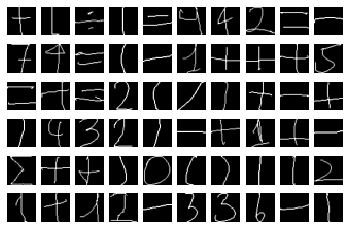

In [0]:
figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

Define network model

In [0]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 25)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x)

Initialize network and define optimizer

In [0]:

network = Net()
optimizer = optim.SGD(network.parameters(), lr=learning_rate,
                      momentum=momentum)


Training function

In [0]:
train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

def train(epoch):
  network.train()
  for batch_idx, (data, target) in enumerate(train_loader):
    optimizer.zero_grad()
    output = network(data)
    loss = F.nll_loss(output, target)
    loss.backward()
    optimizer.step()
    if batch_idx % log_interval == 0:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        epoch, batch_idx * len(data), len(train_loader.dataset),
        100. * batch_idx / len(train_loader), loss.item()))
      train_losses.append(loss.item())
      train_counter.append(
        (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
      torch.save(network.state_dict(), '/model.pth')
      torch.save(optimizer.state_dict(), '/optimizer.pth')

Test function

In [0]:
def test():
  network.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in test_loader:
      output = network(data)
      test_loss += F.nll_loss(output, target, size_average=False).item()
      pred = output.data.max(1, keepdim=True)[1]
      correct += pred.eq(target.data.view_as(pred)).sum()
  test_loss /= len(test_loader.dataset)
  test_losses.append(test_loss)
  print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))

Run training and test functions

In [0]:
test()
for epoch in range(1, n_epochs + 1):
  train(epoch)
  test()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 3.2630, Accuracy: 594/41538 (1%)

Train Epoch: 1 [0/166105 (0%)]	Loss: 3.297716
Train Epoch: 1 [640/166105 (0%)]	Loss: 3.187690
Train Epoch: 1 [1280/166105 (1%)]	Loss: 3.094441
Train Epoch: 1 [1920/166105 (1%)]	Loss: 2.913770
Train Epoch: 1 [2560/166105 (2%)]	Loss: 2.948566
Train Epoch: 1 [3200/166105 (2%)]	Loss: 2.870326
Train Epoch: 1 [3840/166105 (2%)]	Loss: 2.886134
Train Epoch: 1 [4480/166105 (3%)]	Loss: 2.782371
Train Epoch: 1 [5120/166105 (3%)]	Loss: 2.820287
Train Epoch: 1 [5760/166105 (3%)]	Loss: 2.917239
Train Epoch: 1 [6400/166105 (4%)]	Loss: 2.794475
Train Epoch: 1 [7040/166105 (4%)]	Loss: 2.911783
Train Epoch: 1 [7680/166105 (5%)]	Loss: 2.712017
Train Epoch: 1 [8320/166105 (5%)]	Loss: 2.619893
Train Epoch: 1 [8960/166105 (5%)]	Loss: 2.927181
Train Epoch: 1 [9600/166105 (6%)]	Loss: 2.659958
Train Epoch: 1 [10240/166105 (6%)]	Loss: 2.835749
Train Epoch: 1 [10880/166105 (7%)]	Loss: 2.898923
Train Epoch: 1 [11520/166105 (7%)]	Loss: 2.598075
Train Epoch: 1

Plot training and test loss curve

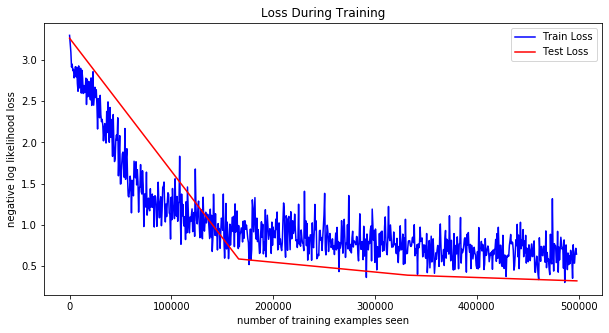

In [0]:
plt.figure(figsize=(10,5))
plt.plot(train_counter, train_losses, color='blue')
plt.plot(test_counter, test_losses, color='red')
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.title("Loss During Training")
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')
plt.show()

Function to view image and predicted value

In [0]:
def view_classify(img, ps):
    ''' Function for viewing an image and it's predicted classes.
    '''
    ps = ps.cpu().data.numpy().squeeze()

    fig = plt.figure()
    plt.imshow(img, cmap='gray', interpolation='none')
    plt.axis('off')
    plt.title("Prediction: {}".format(output.data.max(1, keepdim=True)[1][0].item()))
   
    plt.tight_layout()
    fig

Display several example images from test set and their predicted value

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


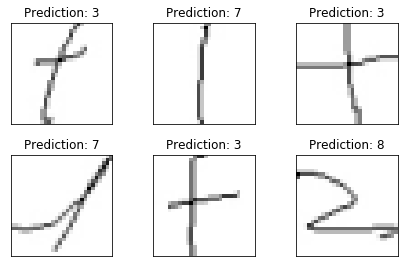

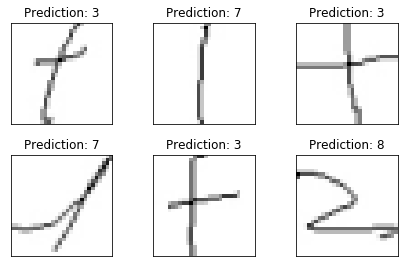

In [0]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

with torch.no_grad():
  output = network(example_data)

fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Prediction: {}".format(
    output.data.max(1, keepdim=True)[1][i].item()))
  plt.xticks([])
  plt.yticks([])
fig

Display one example from test set and its predicted value

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


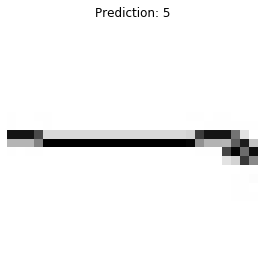

In [0]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

images, labels = next(iter(test_loader))
img = images[0][0]
with torch.no_grad():
    output = network(images)

view_classify(img, output)


Upload an image of a math equation

In [0]:
uploaded = files.upload()
img_file = ""
for fn in uploaded.keys():
  img_file = fn
  print(fn)
  
temp = io.imread(img_file)


Saving test4.png to test4.png
test4.png


Functions to divide the image into sub parts where each part contains a different digit or symbol

loading "test4.png for digit recognition" ...


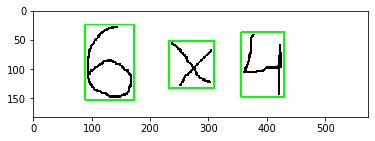

In [0]:
def get_digits(contours, hierarchy):
    hierarchy = hierarchy[0]
    bounding_rectangles = [cv2.boundingRect(ctr) for ctr in contours]   
    final_bounding_rectangles = []
    #find the most common heirarchy level - that is where our digits's bounding boxes are
    u, indices = np.unique(hierarchy[:,-1], return_inverse=True)
    most_common_heirarchy = u[np.argmax(np.bincount(indices))]
    
    for r,hr in zip(bounding_rectangles, hierarchy):
        x,y,w,h = r
        if ((w*h)>250) and (10 <= w <= 200) and (10 <= h <= 200) and hr[3] == most_common_heirarchy: 
            final_bounding_rectangles.append(r)    

    return final_bounding_rectangles

def proc_user_img(img_file):
    print('loading "%s for digit recognition" ...' % img_file)
    im = cv2.imread(img_file)    
    blank_image = np.zeros((im.shape[0],im.shape[1],3), np.uint8)
    blank_image.fill(255)

    imgray = cv2.cvtColor(im,cv2.COLOR_BGR2GRAY)
    plt.imshow(imgray)
    kernel = np.ones((5,5),np.uint8)
    
    ret,thresh = cv2.threshold(imgray,127,255,0)   
    thresh = cv2.erode(thresh,kernel,iterations = 1)
    thresh = cv2.dilate(thresh,kernel,iterations = 1)
    thresh = cv2.erode(thresh,kernel,iterations = 1)
    
    contours,hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    
    digits_rectangles = get_digits(contours,hierarchy)  #rectangles of bounding the digits in user image
    for rect in digits_rectangles:
        x,y,w,h = rect
        cv2.rectangle(im,(x,y),(x+w,y+h),(0,255,0),2)

    plt.imshow(im)
    cv2.imwrite("original_overlay.png",im) 
    cv2.imwrite("final_digits.png",blank_image) 
    cv2.destroyAllWindows()  
    
    return digits_rectangles    
    
    
digit_rectangles = proc_user_img(img_file)

For every rectangle found, input it to our model and get the predicted value

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


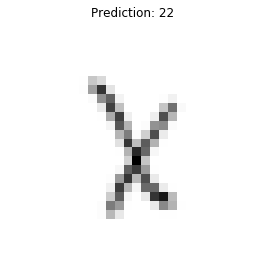

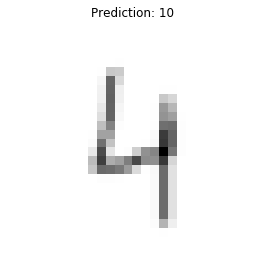

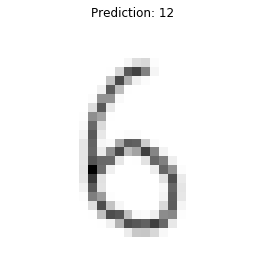

In [0]:
for rect in digit_rectangles:
  x,y,w,h = rect
  temp = rgb2gray(temp)
  cropped = temp[y:(y+h), x:(x+w)]
  cropped = pad(cropped, ((30,30),(70,70)), 'edge')
  image_resized = resize(cropped, (28,28), anti_aliasing=True)
  image_resized = rgb2gray(image_resized)

  input_img =torch.tensor(image_resized).float()
  input_img = input_img.unsqueeze(0)
  input_img = input_img.unsqueeze(0)

  with torch.no_grad():
      output = network(input_img)

  view_classify(image_resized, output)
  